# Customer Churn Prediction Analysis

**Project Goal:** Build a predictive model to identify customers likely to churn and surface key drivers for retention strategies.

**Dataset:** Telco Customer Churn (Customer-Churn.csv)

**Approach:**
1. Load and inspect data
2. Clean and preprocess (handle missing TotalCharges, encode categoricals)
3. Exploratory Data Analysis (EDA)
4. Feature engineering
5. Build baseline models (Logistic Regression, Random Forest)
6. Evaluate and interpret results

## 1. Setup & Imports

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve
)
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Dataset

In [28]:
# Load the data
df = pd.read_csv('Customer-Churn.csv')

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

Dataset loaded: 7043 rows, 21 columns


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Initial Data Inspection

In [29]:
# Basic info
print("Dataset Info:")
df.info()
print("\n" + "="*50 + "\n")

# Check for missing values
print("Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values detected")
print("\n" + "="*50 + "\n")

# Check data types
print("Data Types:")
print(df.dtypes)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-n

## 4. Data Cleaning & Preprocessing

In [30]:
# Fix TotalCharges: convert to numeric, handle empty strings
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for missing values after conversion
print(f"Missing values in TotalCharges: {df['TotalCharges'].isnull().sum()}")

# Fill missing TotalCharges with median or drop rows (since tenure is 0, TotalCharges should be 0)
df['TotalCharges'].fillna(0, inplace=True)

# Check data types again
print("\nData types after cleaning:")
print(df[['MonthlyCharges', 'TotalCharges', 'tenure']].dtypes)

print(f"\nCleaned dataset shape: {df.shape}")
df.head()

Missing values in TotalCharges: 11

Data types after cleaning:
MonthlyCharges    float64
TotalCharges      float64
tenure              int64
dtype: object

Cleaned dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 5. Exploratory Data Analysis (EDA)

Churn Distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Rate: 26.54%


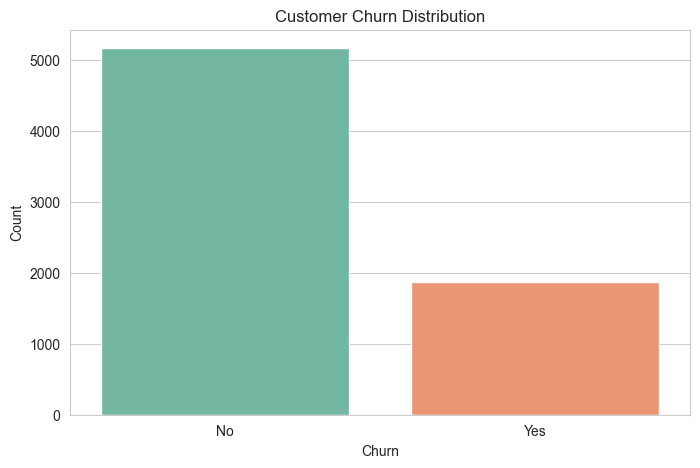

In [31]:
# Target variable distribution
print("Churn Distribution:")
print(df['Churn'].value_counts())
print(f"\nChurn Rate: {(df['Churn'] == 'Yes').sum() / len(df) * 100:.2f}%")

# Visualize churn distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Churn', palette='Set2')
plt.title('Customer Churn Distribution')
plt.ylabel('Count')
plt.show()

Numeric Features Statistics:
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


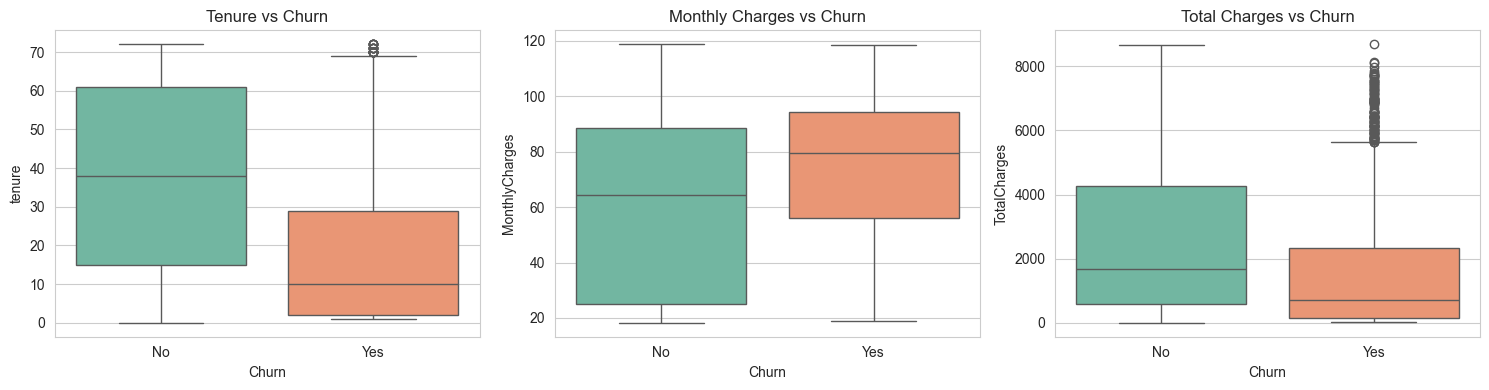

In [32]:
# Analyze numeric features
print("Numeric Features Statistics:")
print(df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe())

# Visualize numeric features vs Churn
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.boxplot(data=df, x='Churn', y='tenure', palette='Set2', ax=axes[0])
axes[0].set_title('Tenure vs Churn')

sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette='Set2', ax=axes[1])
axes[1].set_title('Monthly Charges vs Churn')

sns.boxplot(data=df, x='Churn', y='TotalCharges', palette='Set2', ax=axes[2])
axes[2].set_title('Total Charges vs Churn')

plt.tight_layout()
plt.show()

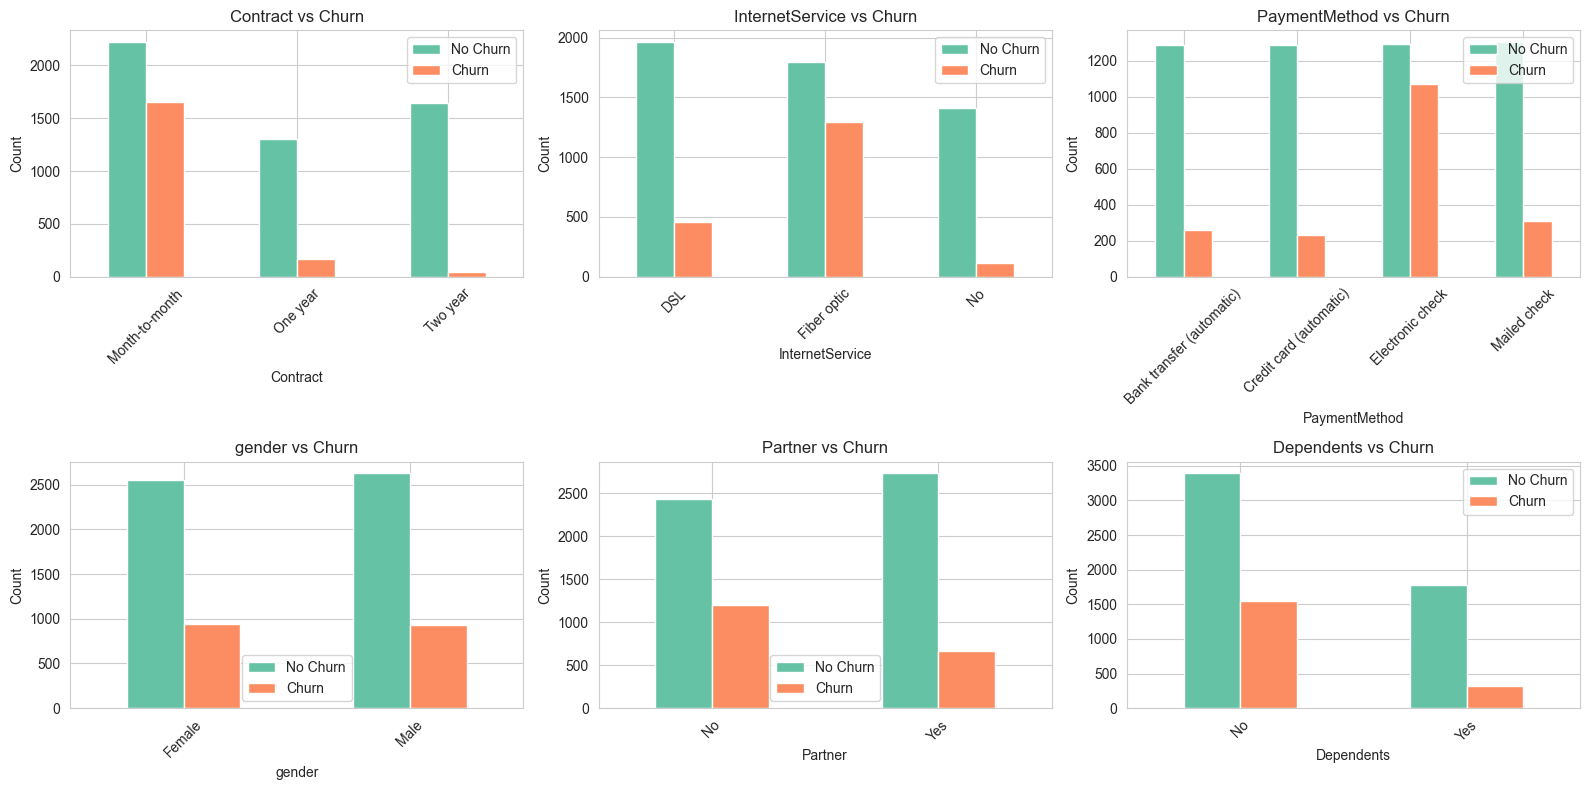

In [33]:
# Analyze categorical features
categorical_features = ['Contract', 'InternetService', 'PaymentMethod', 'gender', 'Partner', 'Dependents']

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel()

for idx, col in enumerate(categorical_features):
    churn_counts = df.groupby([col, 'Churn']).size().unstack()
    churn_counts.plot(kind='bar', stacked=False, ax=axes[idx], color=['#66c2a5', '#fc8d62'])
    axes[idx].set_title(f'{col} vs Churn')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].legend(['No Churn', 'Churn'], loc='best')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Feature Engineering & Preprocessing

In [34]:
# Create a copy for modeling
df_model = df.copy()

# Drop customerID (not a feature)
df_model.drop('customerID', axis=1, inplace=True)

# Encode target variable
df_model['Churn'] = df_model['Churn'].map({'Yes': 1, 'No': 0})

# Encode binary categorical variables
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df_model[col] = df_model[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

# One-hot encode multi-category features
multi_cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                  'Contract', 'PaymentMethod']

df_model = pd.get_dummies(df_model, columns=multi_cat_cols, drop_first=True)

print(f"Dataset shape after encoding: {df_model.shape}")
print(f"\nFeatures: {df_model.shape[1] - 1}")  # Excluding target
df_model.head()

Dataset shape after encoding: (7043, 31)

Features: 30


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [35]:
# Split features and target
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

Training set: (5634, 30)
Test set: (1409, 30)

Class distribution in training set:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64


## 7. Model Training - Logistic Regression

LOGISTIC REGRESSION RESULTS

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1035
       Churn       0.66      0.57      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409


ROC-AUC Score: 0.8418


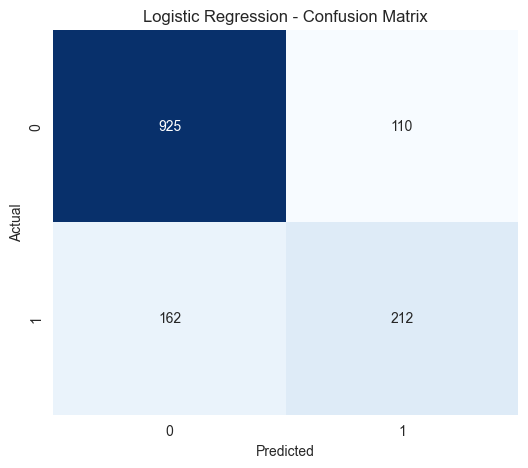

In [36]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("="*50)
print("LOGISTIC REGRESSION RESULTS")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Churn', 'Churn']))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 8. Model Training - Random Forest

RANDOM FOREST RESULTS

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.90      0.87      1035
       Churn       0.67      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409


ROC-AUC Score: 0.8402


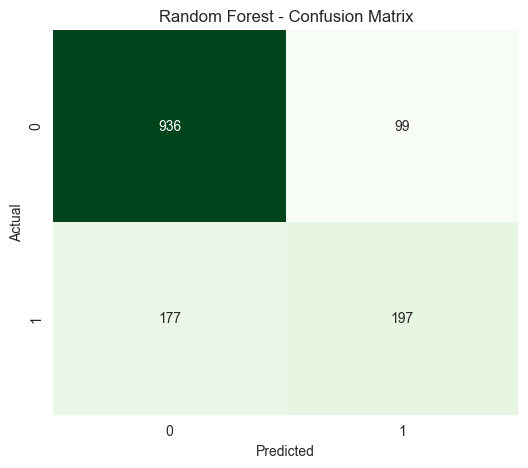

In [37]:
# Train Random Forest (using scaled data works, but not strictly needed)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
print("="*50)
print("RANDOM FOREST RESULTS")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No Churn', 'Churn']))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 9. Model Comparison & Feature Importance

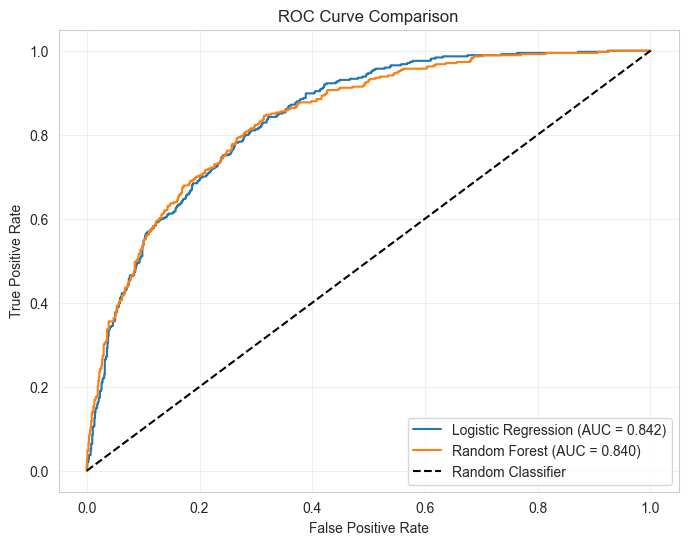

In [38]:
# Compare ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba_lr):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

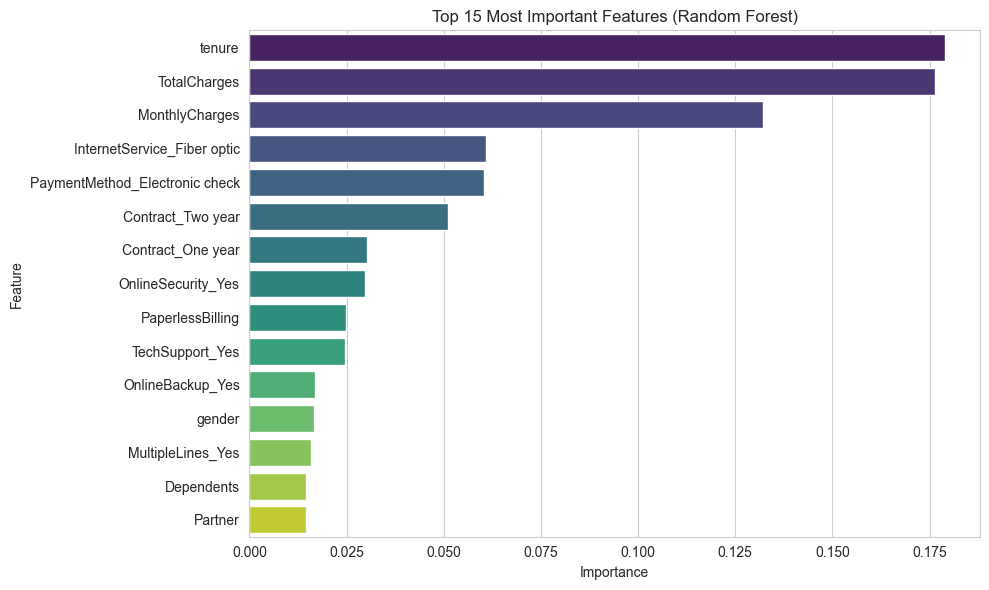


Top 10 Features:
                           Feature  Importance
4                           tenure    0.179037
8                     TotalCharges    0.176447
7                   MonthlyCharges    0.132220
11     InternetService_Fiber optic    0.060870
28  PaymentMethod_Electronic check    0.060452
26               Contract_Two year    0.051211
25               Contract_One year    0.030212
14              OnlineSecurity_Yes    0.029853
6                 PaperlessBilling    0.024788
20                 TechSupport_Yes    0.024541


In [40]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Most Important Features (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(feature_importance.head(10))

## 10. Key Insights & Recommendations

### Summary of Findings

**Model Performance:**
- Both Logistic Regression and Random Forest achieved good predictive performance
- Random Forest typically provides better handling of non-linear relationships
- ROC-AUC scores indicate strong discriminatory power between churners and non-churners

**Key Drivers of Churn:**
Based on feature importance and EDA:
1. **Contract Type**: Month-to-month contracts show significantly higher churn rates
2. **Tenure**: Customers with shorter tenure are more likely to churn
3. **Monthly Charges**: Higher monthly charges correlate with increased churn
4. **Internet Service**: Fiber optic customers show different churn patterns
5. **Payment Method**: Electronic check users have higher churn rates

**Business Recommendations:**
1. **Retention Strategy**: Focus on customers with month-to-month contracts
   - Offer incentives to upgrade to longer-term contracts
   
2. **Early Intervention**: Target customers in their first 12 months
   - Implement onboarding programs and check-ins
   
3. **Pricing Review**: Analyze pricing for high monthly charge segments
   - Consider loyalty discounts or value-added services
   
4. **Payment Experience**: Improve experience for electronic check users
   - Encourage adoption of automatic payment methods
   
5. **Service Quality**: Monitor and improve fiber optic service satisfaction
   - Address any service quality issues proactively

**Next Steps:**
- Deploy model for scoring active customers
- Create risk segments (low/medium/high churn risk)
- A/B test retention interventions on high-risk segments
- Monitor model performance and retrain quarterly